In [1]:
#lib load


In [4]:
!pip install scikeras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor

In [5]:
##dat load


In [6]:
dataset = pd.read_csv('cows_feat.txt', delimiter=',')
X = dataset.drop(columns=['MY1', 'MY2', 'Animal_Number'])
y = dataset[['MY1', 'MY2']]

In [7]:
#jus checking as i got str error in the last keras file


In [8]:
X = X.apply(pd.to_numeric, errors='coerce')
y = y.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.mean())
y = y.fillna(y.mean())

In [11]:
X

,year,month,age,Lactation_Number,Days_In_Milk,RT_mean,RT_variance,AT_mean,AT_variance,temperature_mean,temperature_variance,humidity_mean,humidity_variance,solarradiation_mean,solarradiation_variance,THI_mean,THI_variance
0,2024,5,5.682192,4,280,394.733333,11253.780952,425.000000,11922.428571,61.973333,13.933524,55.826667,64.379238,309.406667,5033.962095,44.471090,14.327018
1,2024,5,5.293151,4,140,546.400000,1646.685714,451.333333,707.523810,67.880000,58.477429,50.993333,76.909238,328.800000,4851.785714,50.858363,63.574137
2,2023,9,2.410959,1,101,485.000000,18254.428571,470.800000,13874.171429,70.526667,5.409238,57.166667,4.320952,213.553333,184.544095,52.450234,5.450942
3,2024,3,2.213699,1,132,591.666667,1184.523810,438.000000,135.000000,55.553333,9.605524,66.733333,41.656667,217.880000,1794.810286,38.717418,7.676363
4,2024,5,2.375342,1,118,556.933333,12529.209524,488.466667,6031.980952,68.173333,58.837810,51.860000,75.745429,329.886667,4902.098381,51.041491,63.715519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,2024,3,2.008219,1,51,503.133333,5484.838095,486.466667,8312.695238,54.160000,5.119714,67.600000,46.790000,205.033333,2072.028095,37.542164,3.165562
854,2024,4,2.079452,1,71,561.733333,22254.352381,435.133333,12882.409524,56.586667,48.559810,66.833333,31.655238,246.386667,5636.701238,39.677269,38.837834
855,2024,6,2.213699,1,132,552.466667,26442.980952,494.666667,16349.523810,73.433333,28.346667,47.166667,22.985238,356.573333,461.364952,56.530359,32.020709
856,2024,5,2.147945,1,91,549.000000,21162.714286,422.133333,12356.980952,69.313333,47.701238,51.153333,47.205524,348.280000,137.341714,51.997754,54.912258


In [13]:
#TTV split

In [14]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)


In [15]:
##model func

In [16]:
def build_model(neurons=32, dropout_rate=0.2, learning_rate=0.001, optimizer='adam'):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(neurons * 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(2, activation='linear'))

    #opt define
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")

    ###compile
    model.compile(optimizer=opt, loss='mse', metrics=['mse', 'mae'])
    return model

In [17]:
#wrap an early stop

In [18]:
keras_reg = KerasRegressor(
    build_model,
    verbose=0,
    neurons=32,
    dropout_rate=0.2,
    learning_rate=0.001,
    optimizer='adam',
    batch_size=32,
    epochs=50,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

In [19]:
#pam grid for RANDOM Cv

In [20]:
param_dist = {
    'neurons': [32, 64, 128, 256, 512],
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32, 64, 128],
    'epochs': [50, 100, 150]
}

In [21]:
#actual R_CV

In [22]:
random_search = RandomizedSearchCV(
    estimator=keras_reg,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42
)

In [23]:
#fit and model

In [24]:
random_search.fit(X_train, y_train)


print("Best Parameters:", random_search.best_params_)
print("Best Score (Negative MSE):", random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mse
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarnin

Best Parameters: {'optimizer': 'adam', 'neurons': 256, 'learning_rate': 0.01, 'epochs': 150, 'dropout_rate': 0.2, 'batch_size': 32}
Best Score (Negative MSE): -156.78758015389664


In [25]:
#Evaluation

In [26]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)


In [27]:
#r squ

In [28]:
r2_my1 = r2_score(y_test['MY1'], y_pred[:, 0])
r2_my2 = r2_score(y_test['MY2'], y_pred[:, 1])
print(f"R-squared for MY1: {r2_my1:.4f}")
print(f"R-squared for MY2: {r2_my2:.4f}")

R-squared for MY1: -0.2370
R-squared for MY2: -0.3896


In [ ]:
#runing the best fit so that the viz can be obtained at single keras history


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 168095792.0000 - mae: 3903.2024 - val_loss: 3509.3813 - val_mae: 49.9676
Epoch 2/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6922.1816 - mae: 59.6286 - val_loss: 1409.8158 - val_mae: 23.6758
Epoch 3/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1345.2542 - mae: 25.8399 - val_loss: 694.9194 - val_mae: 18.5307
Epoch 4/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 723.0690 - mae: 19.9558 - val_loss: 584.7435 - val_mae: 16.6849
Epoch 5/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 527.4885 - mae: 17.4407 - val_loss: 651.2656 - val_mae: 21.6712
Epoch 6/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 588.5769 - mae: 19.0447 - val_loss: 435.1627 - val_mae: 16.0832
Epoch 7/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 411.5505 - mae: 15.7973 - val_loss: 422.1012 - val_mae: 16.7352
Epoch 8/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 444.3169 - mae: 16.3360 - val_loss: 375.4374 - val_mae: 15.5602


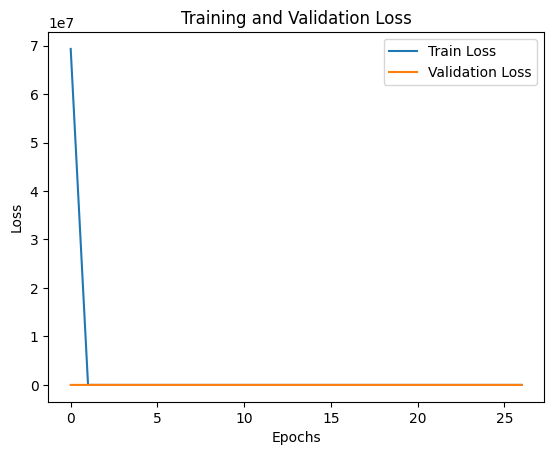

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

dataset = pd.read_csv('cows_feat.txt', delimiter=',')
X = dataset.drop(columns=['MY1', 'MY2', 'Animal_Number'])
y = dataset[['MY1', 'MY2']]
X = X.apply(pd.to_numeric, errors='coerce').fillna(X.mean())
y = y.apply(pd.to_numeric, errors='coerce').fillna(y.mean())
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='linear'))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, batch_size=32, callbacks=[early_stopping], verbose=1)

y_pred = model.predict(X_test)
r2_my1 = r2_score(y_test['MY1'], y_pred[:, 0])
r2_my2 = r2_score(y_test['MY2'], y_pred[:, 1])
print(f"R-squared for MY1: {r2_my1:.4f}")
print(f"R-squared for MY2: {r2_my2:.4f}")

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()
